In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [44]:
NOISE_DIM = 100  
BATCH_SIZE = 4 
STEPS_PER_EPOCH = 4000
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

In [42]:
MAIN_DIR = "../input/brain-mri-images-for-brain-tumor-detection/yes"

In [7]:
def load_images(folder):
    
    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue
        
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data(images, labels):
    """
    Apply augmentation to the input images to artificially increase the dataset size.
    """
    data_gen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    augmented_images = []
    augmented_labels = []

    # Iterate through the original images and labels to augment data
    for img, label in zip(images, labels):
        img = img.reshape((1, *img.shape, 1))  # Add batch and channel dimensions
        aug_iter = data_gen.flow(img, batch_size=1)  # Generate batches of augmented images
        for _ in range(5):  # Generate 5 augmented samples per image
            augmented_img = next(aug_iter)[0].reshape(WIDTH, HEIGHT)
            augmented_images.append(augmented_img)
            augmented_labels.append(label)
    
    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_labels

# Load and augment the dataset
data, labels = load_images(MAIN_DIR)
augmented_data, augmented_labels = augment_data(data, labels)

# Combine original and augmented datasets
data_combined = np.concatenate((data, augmented_data), axis=0)
labels_combined = np.concatenate((labels, augmented_labels), axis=0)

# Shuffle the dataset
np.random.seed(SEED)
shuffle_indices = np.random.permutation(data_combined.shape[0])
data_combined = data_combined[shuffle_indices]
labels_combined = labels_combined[shuffle_indices]

# Normalize and reshape the combined dataset
data_combined = (data_combined.astype(np.float32) - 127.5) / 127.5
data_combined = data_combined.reshape(-1, WIDTH, HEIGHT, CHANNELS)

print("Augmented Dataset Shape:", data_combined.shape, labels_combined.shape)


Augmented Dataset Shape: (930, 128, 128, 1) (930,)


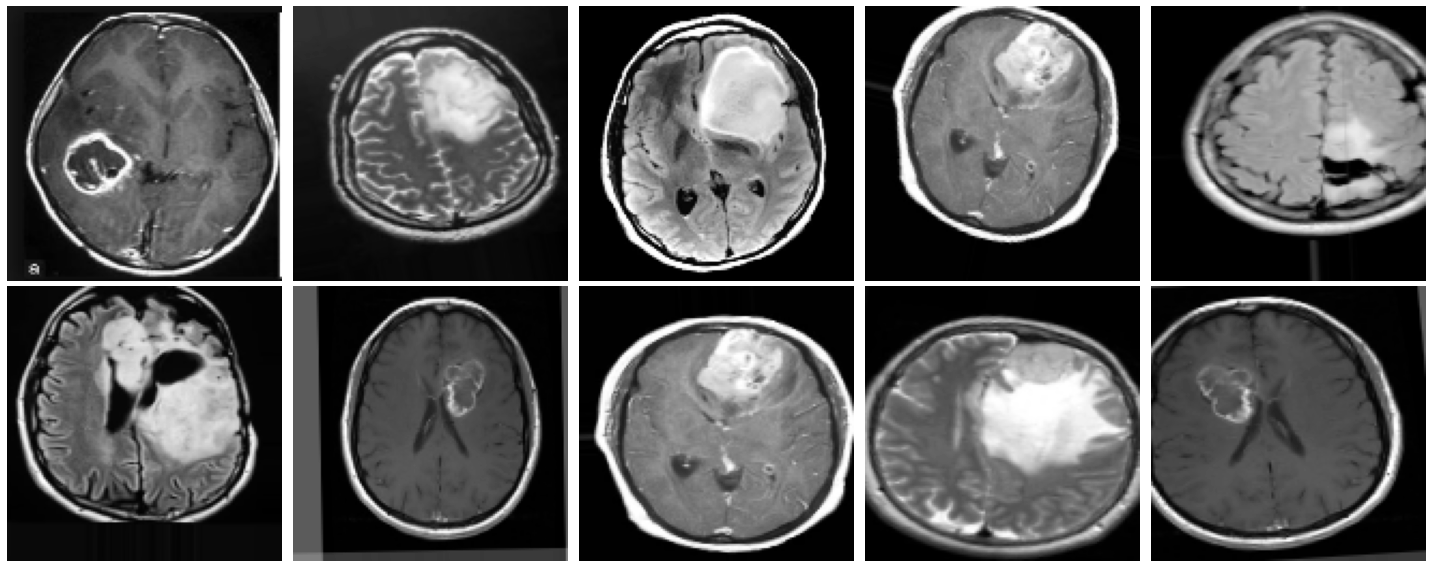

In [9]:
plt.figure(figsize=(20, 8))
for i in range(10):
    axs = plt.subplot(2, 5, i + 1)
    plt.imshow(data_combined[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
plt.tight_layout()
plt.show()


In [10]:
# Print the number of images before augmentation
print(f"Number of original images: {data.shape[0]}")

# Print the number of augmented images
print(f"Number of augmented images: {augmented_data.shape[0]}")

# Print the total number of images after combining original and augmented data
print(f"Total number of images in the dataset: {data_combined.shape[0]}")


Number of original images: 155
Number of augmented images: 775
Total number of images in the dataset: 930


In [13]:
def random_brightness(images):
    return np.array([cv2.convertScaleAbs(img, alpha=np.random.uniform(0.8, 1.2), beta=np.random.randint(-30, 30)) for img in images])


In [15]:
# Ensure all images have the same shape after augmentation
def random_brightness(images):
    return np.array([cv2.resize(cv2.convertScaleAbs(img, alpha=np.random.uniform(0.8, 1.2), beta=np.random.randint(-30, 30)), (128, 128)) for img in images])

def random_contrast(images):
    return np.array([cv2.resize(cv2.convertScaleAbs(img, alpha=np.random.uniform(0.8, 1.5), beta=0), (128, 128)) for img in images])

def add_noise(images):
    noisy_images = []
    for img in images:
        noise = np.random.normal(0, 10, img.shape)
        noisy_img = np.clip(img + noise, 0, 255).astype(np.uint8)
        noisy_images.append(cv2.resize(noisy_img, (128, 128)))
    return np.array(noisy_images)

def random_rotation(images, angle_range=15):
    rotated_images = []
    for img in images:
        angle = np.random.uniform(-angle_range, angle_range)
        center = (img.shape[1] // 2, img.shape[0] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_img = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))
        rotated_images.append(cv2.resize(rotated_img, (128, 128)))
    return np.array(rotated_images)

def random_flipping(images):
    flipped_images = []
    for img in images:
        flip_code = np.random.choice([-1, 0, 1])  # -1: Both axes, 0: Vertical, 1: Horizontal
        flipped_img = cv2.flip(img, flip_code)
        flipped_images.append(cv2.resize(flipped_img, (128, 128)))
    return np.array(flipped_images)

def random_zoom(images, zoom_range=(0.9, 1.1)):
    zoomed_images = []
    for img in images:
        zoom = np.random.uniform(*zoom_range)
        height, width = img.shape[:2]
        new_height, new_width = int(height * zoom), int(width * zoom)
        zoomed_img = cv2.resize(img, (new_width, new_height))
        if zoom > 1.0:
            crop_h = (new_height - height) // 2
            crop_w = (new_width - width) // 2
            zoomed_img = zoomed_img[crop_h:crop_h + height, crop_w:crop_w + width]
        else:
            pad_h = (height - new_height) // 2
            pad_w = (width - new_width) // 2
            zoomed_img = cv2.copyMakeBorder(zoomed_img, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_REFLECT)
        zoomed_images.append(cv2.resize(zoomed_img, (128, 128)))
    return np.array(zoomed_images)


In [16]:
# Apply augmentations
brightness_images = random_brightness(data)
contrast_images = random_contrast(data)
noisy_images = add_noise(data)
rotated_images = random_rotation(data)
flipped_images = random_flipping(data)
zoomed_images = random_zoom(data)

# Combine all augmented datasets
augmented_data = np.concatenate((
    brightness_images, contrast_images, noisy_images,
    rotated_images, flipped_images, zoomed_images
), axis=0)

# Combine with original data
data_combined = np.concatenate((data, augmented_data), axis=0)

# Print final number of images
final_number_of_images = data_combined.shape[0]
print(f"Final number of images in the dataset: {final_number_of_images}")


Final number of images in the dataset: 1085


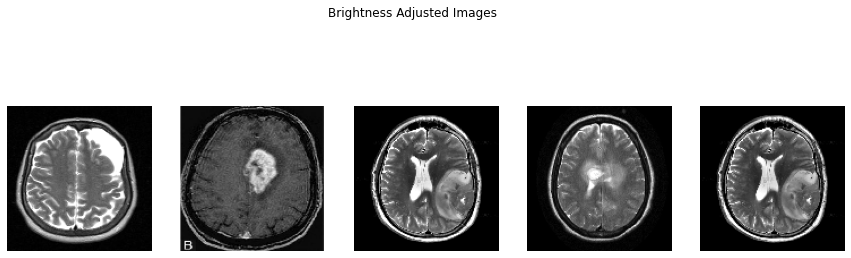

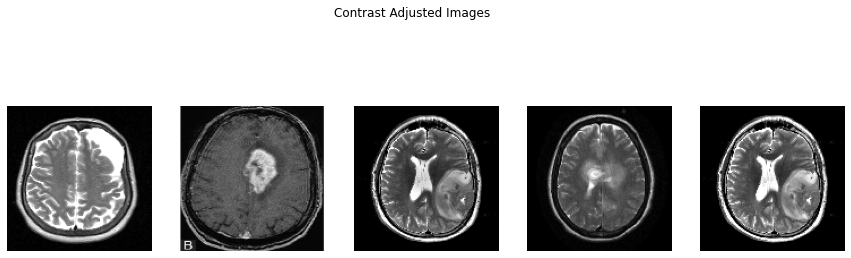

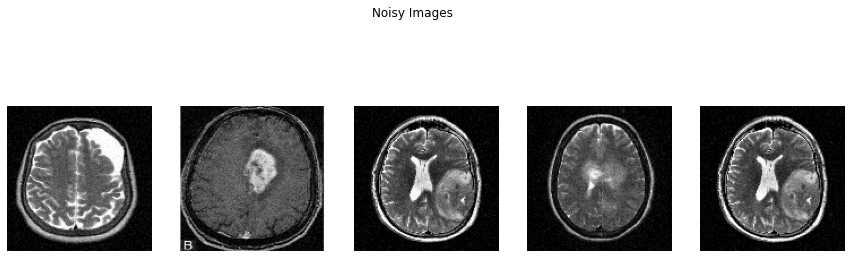

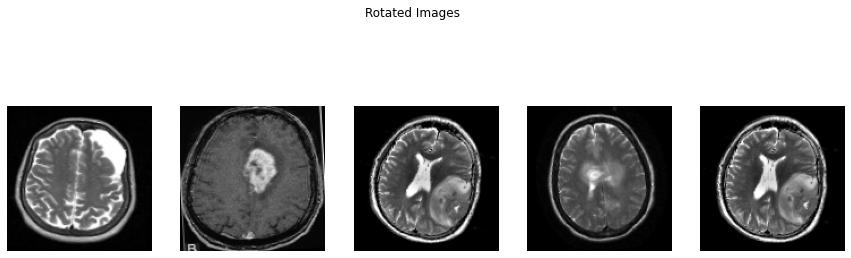

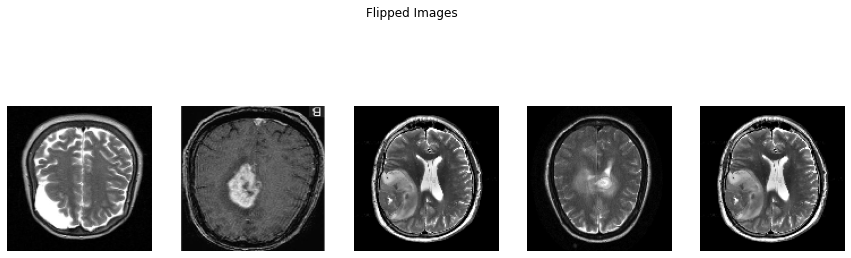

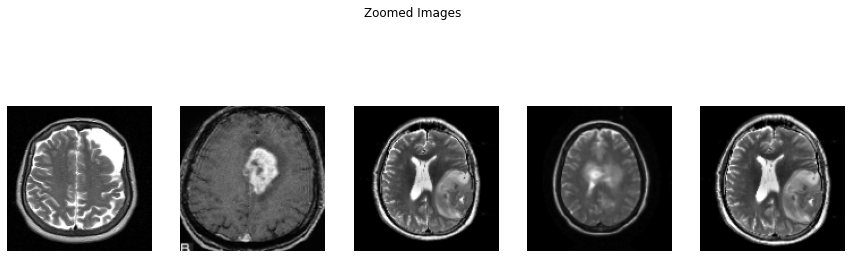

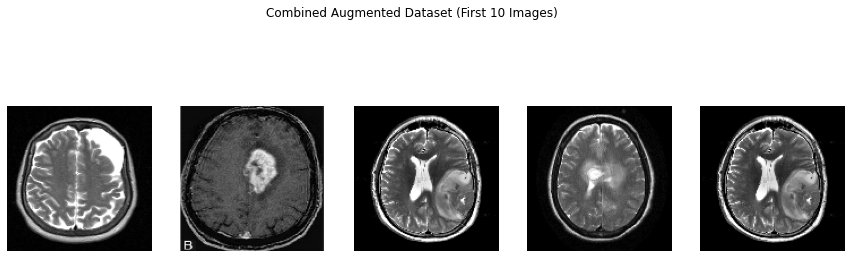

In [17]:
# Visualize a few examples from each augmentation to verify correctness
import matplotlib.pyplot as plt

# Function to display images from a dataset
def display_images(images, title, num=5):
    plt.figure(figsize=(15, 5))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display a few examples from each augmentation
display_images(brightness_images, "Brightness Adjusted Images")
display_images(contrast_images, "Contrast Adjusted Images")
display_images(noisy_images, "Noisy Images")
display_images(rotated_images, "Rotated Images")
display_images(flipped_images, "Flipped Images")
display_images(zoomed_images, "Zoomed Images")

# Display a few examples from the combined augmented dataset
display_images(augmented_data[:10], "Combined Augmented Dataset (First 10 Images)")


In [8]:
np.random.seed(SEED)
idxs = np.random.randint(0, 155, 20)

In [9]:
X_train = data[idxs]
X_train.shape

(20, 128, 128)

In [21]:
# Shuffle the dataset
np.random.seed(42)  # For reproducibility
shuffle_indices = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffle_indices]


In [20]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Training set shape: (868, 128, 128, 1)
Validation set shape: (217, 128, 128, 1)


In [24]:
from sklearn.model_selection import train_test_split

# Assign combined data to dataset
X_combined = data_combined

# Ensure correct shape for grayscale images (adding channel dimension)
X_combined = X_combined[..., np.newaxis]  # Add a channel dimension for grayscale images

# Normalize the Images
X_combined = (X_combined.astype(np.float32) - 127.5) / 127.5

# Split the dataset into training and validation sets
X_train, X_val = train_test_split(X_combined, test_size=0.2, random_state=42)

# Print the shapes of the training and validation sets
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Training set shape: (868, 128, 128, 1)
Validation set shape: (217, 128, 128, 1)


## Plotting The Real Images

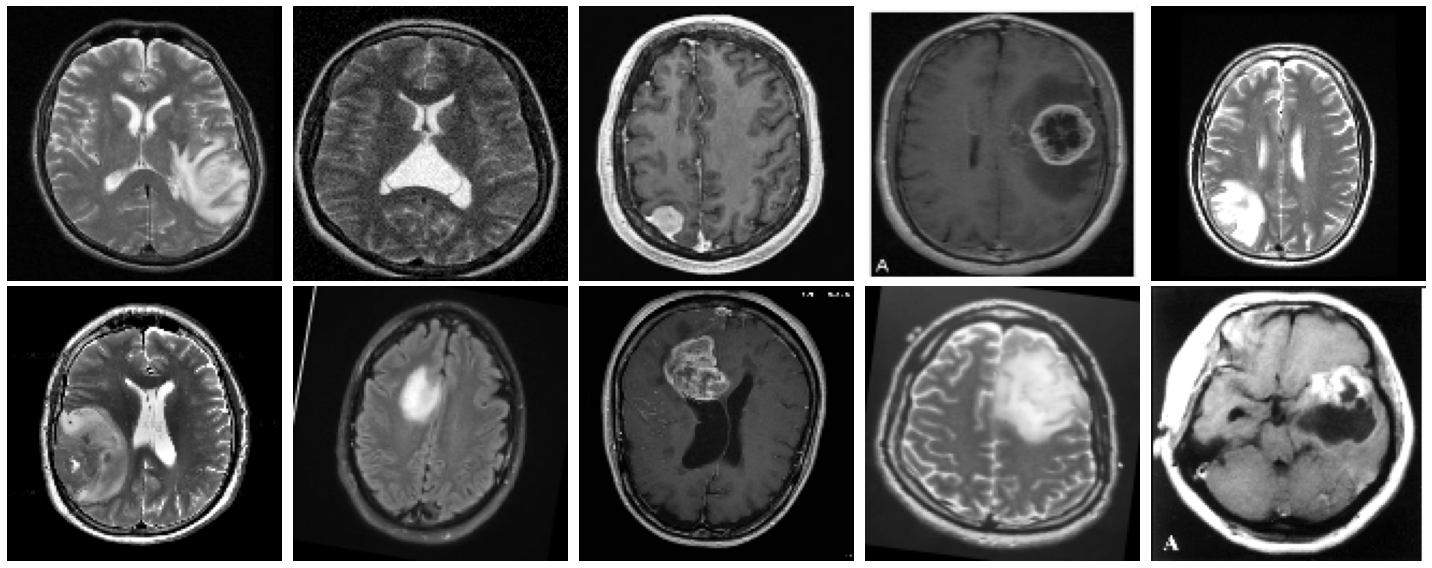

In [22]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

In [35]:
def build_generator():

    """
        Generator model "generates" images using random noise. The random noise AKA Latent Vector
        is sampled from a Normal Distribution which is given as the input to the Generator. Using
        Transposed Convolution, the latent vector is transformed to produce an image
        We use 3 Conv2DTranspose layers (which help in producing an image using features; opposite
        of Convolutional Learning)

        Input: Random Noise / Latent Vector
        Output: Image
    """

    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),
        
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ], 
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model


In [36]:
def build_discriminator():
    
    """
        Discriminator is the model which is responsible for classifying the generated images
        as fake or real. Our end goal is to create a Generator so powerful that the Discriminator
        is unable to classify real and fake images
        A simple Convolutional Neural Network with 2 Conv2D layers connected to a Dense output layer
        Output layer activation is Sigmoid since this is a Binary Classifier

        Input: Generated / Real Image
        Output: Validity of Image (Fake or Real)

    """

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

In [37]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False 

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()



Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 256)   


Epoch 1/10


Training Epoch 1: 100%|██████████| 4000/4000 [05:28<00:00, 12.17it/s]


EPOCH 1: Generator Loss: 2.3508, Discriminator Loss: 0.5150, Time: 328.60s


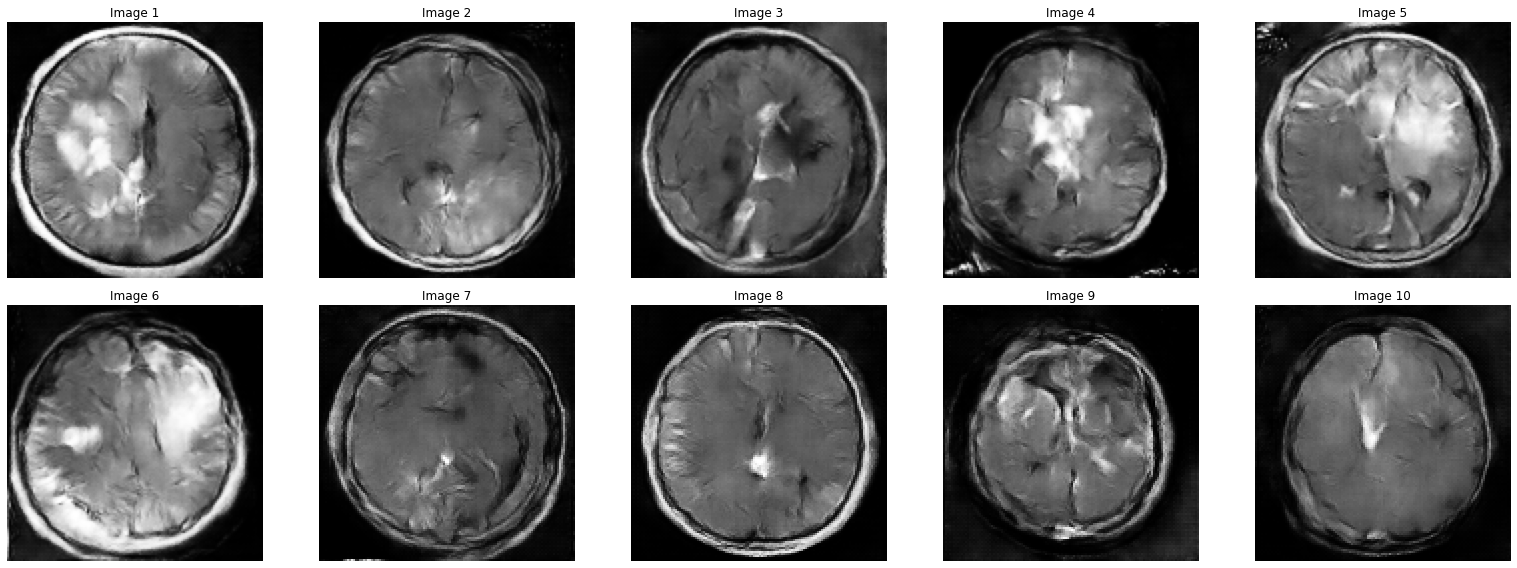


Epoch 2/10


Training Epoch 2: 100%|██████████| 4000/4000 [05:11<00:00, 12.85it/s]


EPOCH 2: Generator Loss: 4.4583, Discriminator Loss: 0.3000, Time: 311.36s


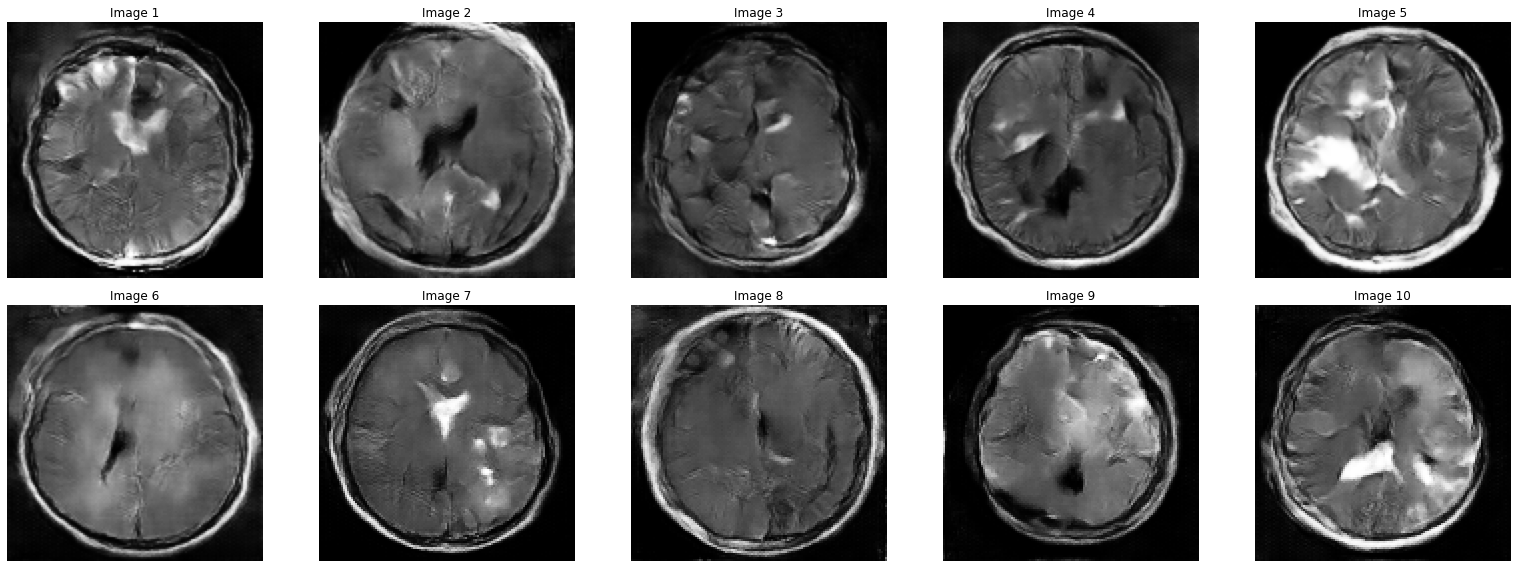


Epoch 3/10


Training Epoch 3: 100%|██████████| 4000/4000 [05:15<00:00, 12.69it/s]


EPOCH 3: Generator Loss: 2.1176, Discriminator Loss: 0.2176, Time: 315.09s


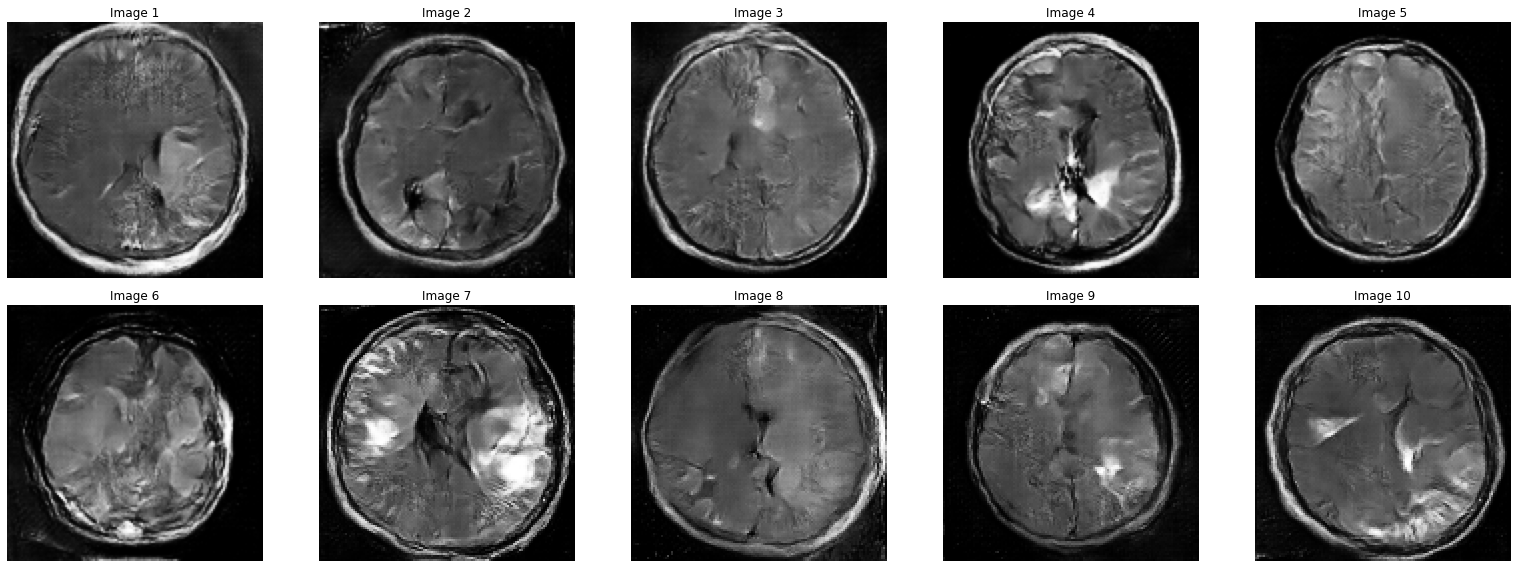


Epoch 4/10


Training Epoch 4: 100%|██████████| 4000/4000 [05:13<00:00, 12.76it/s]


EPOCH 4: Generator Loss: 2.9684, Discriminator Loss: 0.1306, Time: 313.44s


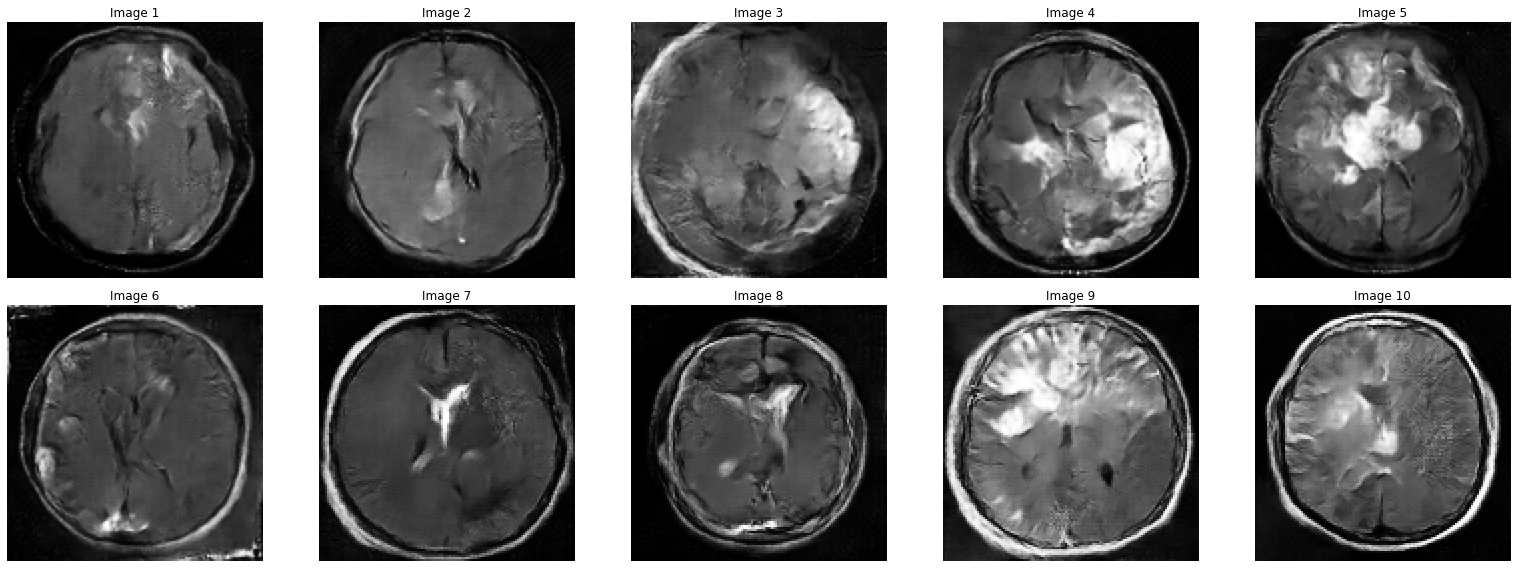


Epoch 5/10


Training Epoch 5: 100%|██████████| 4000/4000 [05:13<00:00, 12.75it/s]


EPOCH 5: Generator Loss: 2.6489, Discriminator Loss: 0.7254, Time: 313.69s


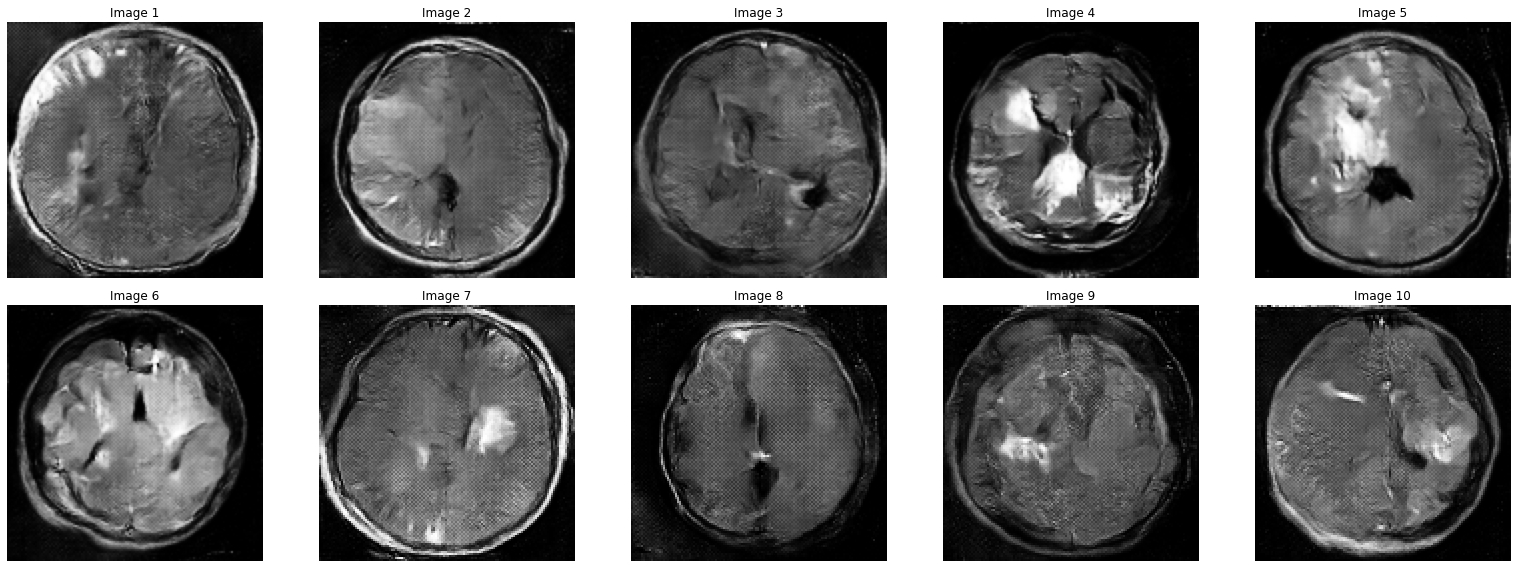


Epoch 6/10


Training Epoch 6: 100%|██████████| 4000/4000 [05:16<00:00, 12.63it/s]


EPOCH 6: Generator Loss: 6.0560, Discriminator Loss: 0.0363, Time: 316.74s


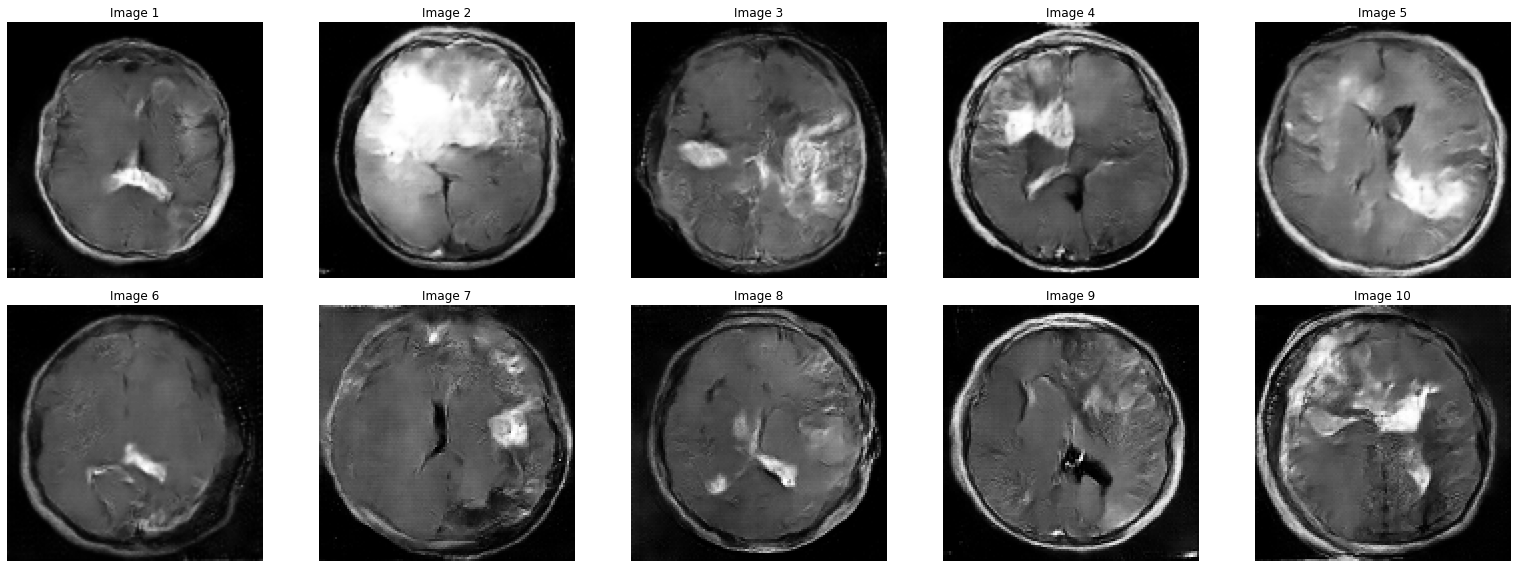


Epoch 7/10


Training Epoch 7: 100%|██████████| 4000/4000 [05:18<00:00, 12.54it/s]


EPOCH 7: Generator Loss: 5.8352, Discriminator Loss: 0.1030, Time: 319.00s


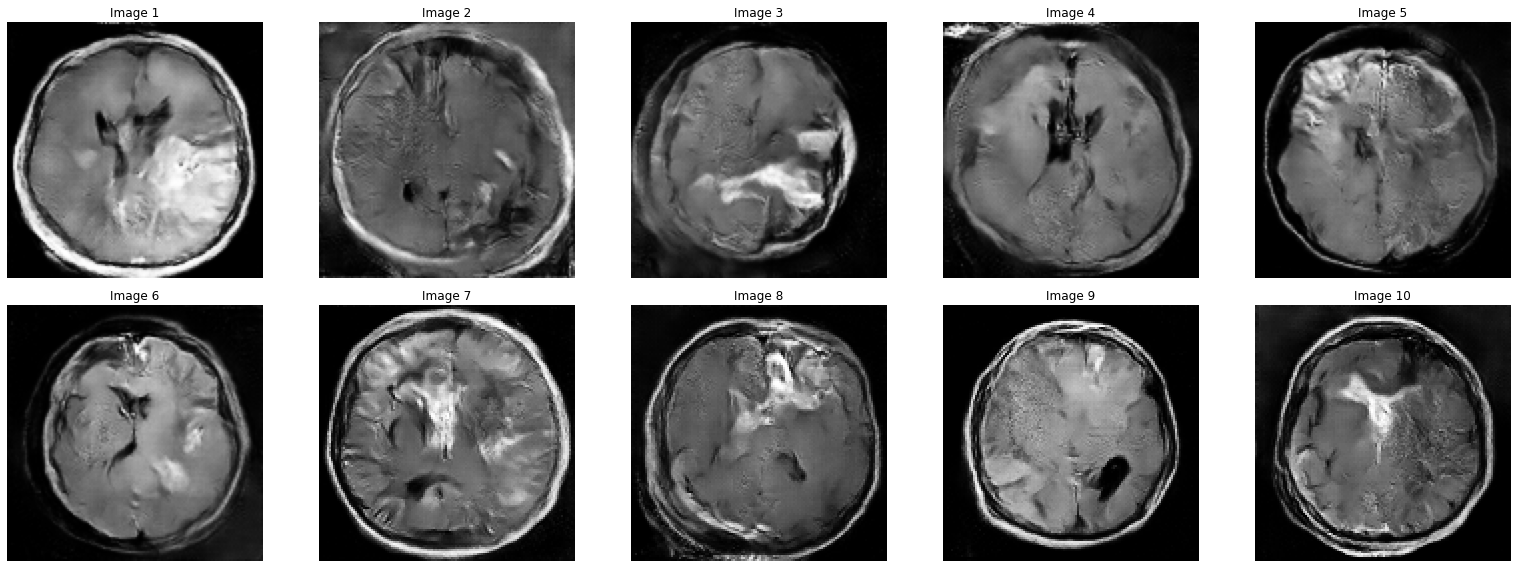


Epoch 8/10


Training Epoch 8: 100%|██████████| 4000/4000 [05:15<00:00, 12.66it/s]


EPOCH 8: Generator Loss: 6.5043, Discriminator Loss: 0.0117, Time: 315.94s


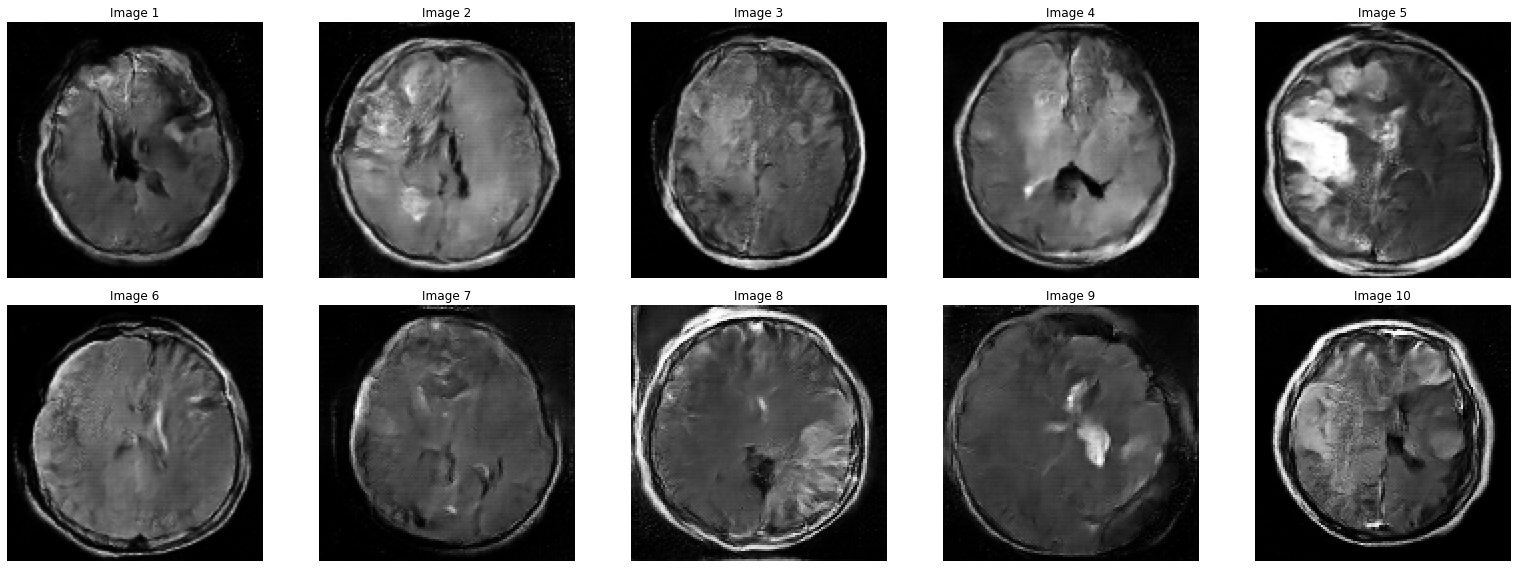


Epoch 9/10


Training Epoch 9: 100%|██████████| 4000/4000 [05:17<00:00, 12.59it/s]


EPOCH 9: Generator Loss: 6.3324, Discriminator Loss: 0.0032, Time: 317.79s


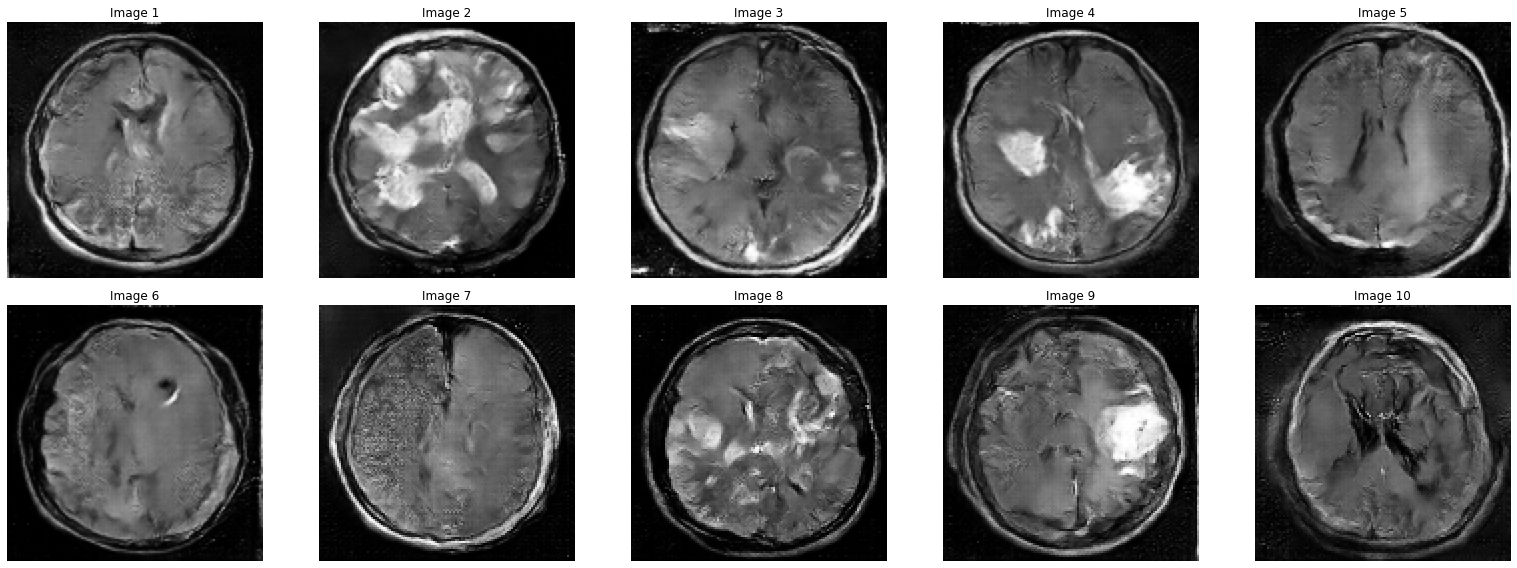


Epoch 10/10


Training Epoch 10: 100%|██████████| 4000/4000 [05:18<00:00, 12.56it/s]


EPOCH 10: Generator Loss: 7.4986, Discriminator Loss: 0.2610, Time: 318.56s


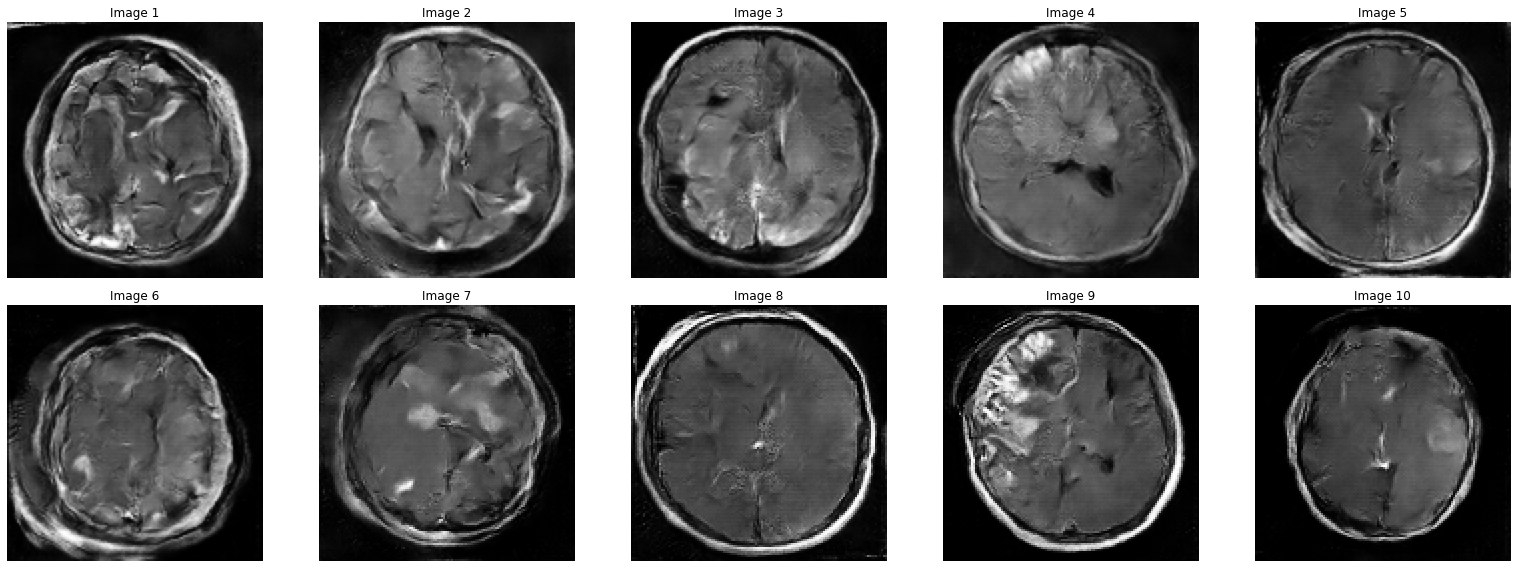


Training Completed in 3177.82s


In [45]:
import numpy as np
from tqdm import tqdm
import time

# Set random seed for reproducibility
np.random.seed(SEED)

# Initialize variables for logging
d_loss_history = []
g_loss_history = []
start_time = time.time()

# Training loop
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    epoch_start_time = time.time()
    
    for batch in tqdm(range(STEPS_PER_EPOCH), desc=f"Training Epoch {epoch + 1}"):
        
        # Generate noise for the generator
        noise = np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)

        # Get a batch of real images from the training data
        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        # Combine real and fake images
        X = np.concatenate((real_X, fake_X), axis=0)

        # Create labels: real images (1), fake images (0)
        disc_y = np.zeros(2 * BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        # Train the discriminator
        d_loss = discriminator.train_on_batch(X, disc_y)

        # Train the generator (via the GAN model)
        y_gen = np.ones(BATCH_SIZE)  # Labels for generator training are all 1 (real)
        g_loss = gan.train_on_batch(noise, y_gen)

        # Log the losses
        d_loss_history.append(d_loss)
        g_loss_history.append(g_loss)

    # Epoch timing
    epoch_duration = time.time() - epoch_start_time
    print(f"EPOCH {epoch + 1}: Generator Loss: {g_loss:.4f}, Discriminator Loss: {d_loss:.4f}, Time: {epoch_duration:.2f}s")
    
    # Generate and visualize images at the end of each epoch
    noise = np.random.normal(0, 1, size=(10, NOISE_DIM))
    visualize_generated_images(generator, noise, subplots=(2, 5), show_titles=True, save=True, save_dir=f"epoch_{epoch + 1}_images")

# Total training time
total_training_time = time.time() - start_time
print(f"\nTraining Completed in {total_training_time:.2f}s")

# Save the model weights
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")
gan.save("gan_model.h5")


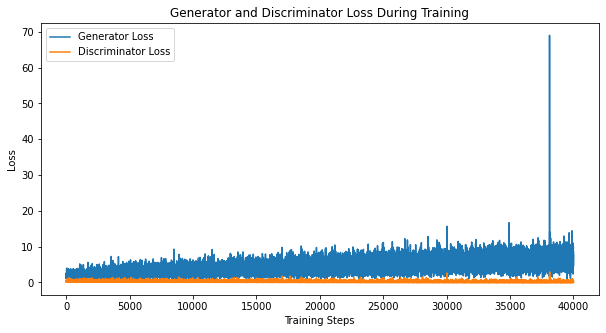

In [46]:
import matplotlib.pyplot as plt

# Plot generator and discriminator losses
plt.figure(figsize=(10, 5))
plt.plot(g_loss_history, label="Generator Loss")
plt.plot(d_loss_history, label="Discriminator Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Loss During Training")
plt.show()


In [47]:
# Save models
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")
gan.save("gan_model.h5")

# Load models later
from keras.models import load_model
generator = load_model("generator_model.h5")
discriminator = load_model("discriminator_model.h5")


In [48]:
# Generate new images
noise = np.random.normal(0, 1, size=(10, NOISE_DIM))
generated_images = generator.predict(noise)

# Save generated images
for i, img in enumerate(generated_images):
    plt.imsave(f"generated_image_{i + 1}.png", img.reshape((WIDTH, HEIGHT)), cmap="gray")


In [49]:
def visualize_comparison(generator, real_images, noise, subplots, figsize=(20, 10)):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    for i in range(subplots[1]):
        # Plot real images
        plt.subplot(subplots[0], subplots[1], i + 1)
        plt.imshow(real_images[i].reshape((WIDTH, HEIGHT)), cmap="gray")
        plt.title("Real Image")
        plt.axis("off")

        # Plot generated images
        plt.subplot(subplots[0], subplots[1], i + 1 + subplots[1])
        plt.imshow(generated_images[i].reshape((WIDTH, HEIGHT)), cmap="gray")
        plt.title("Generated Image")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


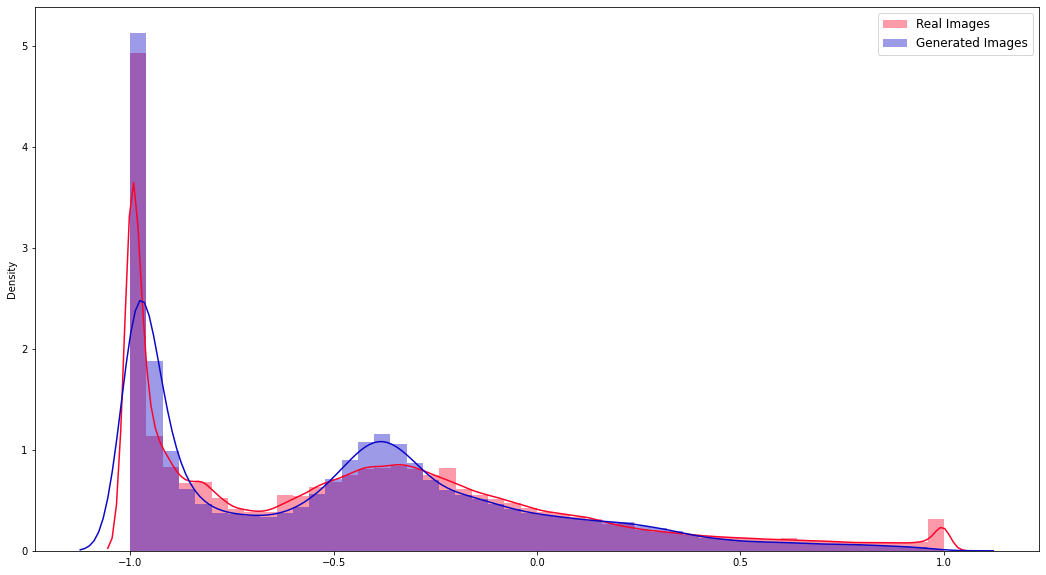

In [51]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

sns.distplot(X_train, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()

In [129]:
from scipy.stats import wasserstein_distance

def calculate_wasserstein_metric(real_images, generated_images):
    """
    Calculate the Wasserstein Metric (Earth Mover's Distance) between real and generated images.
    """
    real_images_flattened = real_images.reshape(real_images.shape[0], -1)
    generated_images_flattened = generated_images.reshape(generated_images.shape[0], -1)

    # Compute Wasserstein Distance for each feature
    distances = [
        wasserstein_distance(real_images_flattened[:, i], generated_images_flattened[:, i])
        for i in range(real_images_flattened.shape[1])
    ]

    return np.mean(distances)

# Example Usage
wasserstein_dist = calculate_wasserstein_metric(X_train, generated_images)
print(f"Wasserstein Metric: {wasserstein_dist}")


Wasserstein Metric: 1.2558064607249935


In [55]:
def load_real_images(data_dir):
    """
    Load real MRI images from the dataset directory with labels.
    - 'yes' directory contains images with tumors (label=1).
    - 'no' directory contains images without tumors (label=0).
    """
    images, labels = [], []
    for label, subdir in enumerate(['no', 'yes']):  # 0 for 'no', 1 for 'yes'
        subdir_path = os.path.join(data_dir, subdir)
        for img_file in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img_file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (128, 128))  # Resize images to 128x128
                images.append(img)
                labels.append(label)
            except:
                continue
    return np.array(images), np.array(labels)

# Load real dataset
data_dir = "../input/brain-mri-images-for-brain-tumor-detection"
real_images, real_labels = load_real_images(data_dir)


print(f"Loaded {real_images.shape[0]} real images with labels: {real_labels.shape}")


Loaded 253 real images with labels: (253,)


In [57]:
# Ensure real_images has a channel dimension
real_images = real_images[..., np.newaxis]  # Add channel dimension

# Normalize images
real_images = real_images.astype('float32') / 255.0
generated_images = (generated_images.astype('float32') - 127.5) / 127.5  # Assuming GAN normalization

# Concatenate real and generated images
combined_images = np.concatenate((real_images, generated_images), axis=0)

# Create combined labels
combined_labels = np.concatenate((real_labels, [0] * len(generated_images)))

print(f"Combined Images Shape: {combined_images.shape}")
print(f"Combined Labels Shape: {combined_labels.shape}")


Combined Images Shape: (263, 128, 128, 1)
Combined Labels Shape: (263,)


TensorFlow version: 2.6.4
Total original images: 253
Total augmented images: 1265
Total combined images: 1518


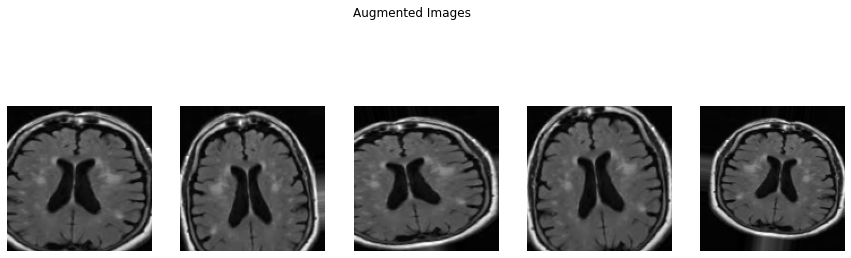

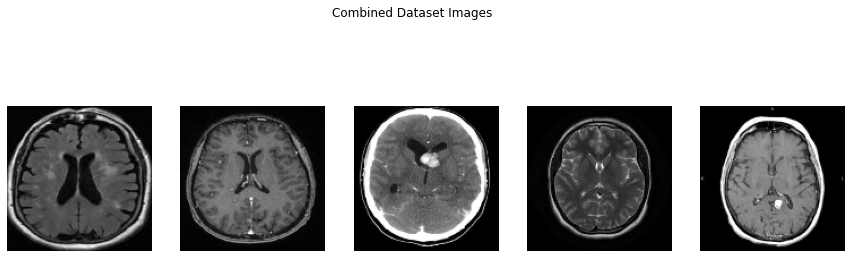

In [61]:
# Ensure TensorFlow is available in your environment to execute the code.
try:
    import tensorflow as tf
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("TensorFlow is not installed. Please install it using `pip install tensorflow`.")
    tf = None

if tf:
    import os
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Load real images and labels
    def load_real_images(data_dir):
        images, labels = [], []
        for label, subdir in enumerate(['no', 'yes']):  # 0 for 'no', 1 for 'yes'
            subdir_path = os.path.join(data_dir, subdir)
            for img_file in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, img_file)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (128, 128))
                    images.append(img)
                    labels.append(label)
                except:
                    continue
        return np.array(images), np.array(labels)

    # Dataset directory
    data_dir = "../input/brain-mri-images-for-brain-tumor-detection"

    # Load real images
    real_images, real_labels = load_real_images(data_dir)

    # Add channel dimension
    real_images = real_images[..., np.newaxis]

    # Normalize images
    real_images = real_images.astype('float32') / 255.0

    # Initialize data augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Augment the dataset
    augmented_images, augmented_labels = [], []
    for img, label in zip(real_images, real_labels):
        img = img.reshape((1, *img.shape))  # Add batch dimension
        aug_iter = datagen.flow(img, batch_size=1)  # Augment image
        for _ in range(5):  # Generate 5 augmented images per original image
            aug_img = next(aug_iter)[0]
            augmented_images.append(aug_img)
            augmented_labels.append(label)

    # Convert augmented data to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    # Combine original and augmented datasets
    combined_images = np.concatenate((real_images, augmented_images), axis=0)
    combined_labels = np.concatenate((real_labels, augmented_labels), axis=0)

    # Print dataset sizes
    print(f"Total original images: {real_images.shape[0]}")
    print(f"Total augmented images: {augmented_images.shape[0]}")
    print(f"Total combined images: {combined_images.shape[0]}")

    # Function to display images
    def display_images(images, title, num=5):
        plt.figure(figsize=(15, 5))
        for i in range(num):
            plt.subplot(1, num, i + 1)
            plt.imshow(images[i].reshape(128, 128), cmap="gray")
            plt.axis('off')
        plt.suptitle(title)
        plt.show()

    # Display augmented images
    display_images(augmented_images[:10], "Augmented Images")

    # Display combined dataset images
    display_images(combined_images[:10], "Combined Dataset Images")


In [64]:
from sklearn.model_selection import train_test_split

# Combined images and labels (real, augmented, and GAN-generated)
# Ensure that combined_images and combined_labels are already prepared
# combined_images shape: (num_samples, 128, 128, 1)
# combined_labels shape: (num_samples,)

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    combined_images, combined_labels, test_size=0.3, random_state=42, stratify=combined_labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Print the dataset splits
print(f"Training Set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation Set: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test Set: {X_test.shape}, Labels: {y_test.shape}")


Training Set: (184, 128, 128, 1), Labels: (184,)
Validation Set: (39, 128, 128, 1), Labels: (39,)
Test Set: (40, 128, 128, 1), Labels: (40,)


In [47]:
import platform
import psutil
import tensorflow as tf

def get_system_config():
    """
    Fetch and display system configuration details.
    """
    system_config = {
        "Processor": platform.processor(),
        "CPU Cores": psutil.cpu_count(logical=True),
        "RAM": f"{round(psutil.virtual_memory().total / 1e9, 2)} GB",
        "Python Version": platform.python_version(),
        "TensorFlow Version": tf.__version__,
        "GPU Available": tf.config.list_physical_devices('GPU')
    }

    # Print system configuration
    print("\nSystem Configuration:")
    for key, value in system_config.items():
        print(f"{key}: {value}")

get_system_config()



System Configuration:
Processor: x86_64
CPU Cores: 4
RAM: 33.67 GB
Python Version: 3.7.12
TensorFlow Version: 2.6.4
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [65]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load pre-trained VGG16 without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base layers

# Add custom layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


58900480/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________


In [68]:
# Convert grayscale images to RGB format
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Use the VGG16-based model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load pre-trained VGG16 without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base layers

# Add custom layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_rgb, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")


Epoch 1/20
6/6 [==============================] - 3s 315ms/step - loss: 1.4092 - accuracy: 0.5272 - val_loss: 1.0766 - val_accuracy: 0.5897
Epoch 2/20
6/6 [==============================] - 0s 32ms/step - loss: 0.9322 - accuracy: 0.5272 - val_loss: 0.8016 - val_accuracy: 0.4103
Epoch 3/20
6/6 [==============================] - 0s 32ms/step - loss: 0.7741 - accuracy: 0.4348 - val_loss: 0.6988 - val_accuracy: 0.5897
Epoch 4/20
6/6 [==============================] - 0s 32ms/step - loss: 0.7314 - accuracy: 0.5598 - val_loss: 0.6779 - val_accuracy: 0.5897
Epoch 5/20
6/6 [==============================] - 0s 32ms/step - loss: 0.6813 - accuracy: 0.5543 - val_loss: 0.6826 - val_accuracy: 0.5897
Epoch 6/20
6/6 [==============================] - 0s 32ms/step - loss: 0.6886 - accuracy: 0.5761 - val_loss: 0.6828 - val_accuracy: 0.5897
Epoch 7/20
6/6 [==============================] - 0s 32ms/step - loss: 0.6918 - accuracy: 0.5435 - val_loss: 0.6787 - val_accuracy: 0.5897
Epoch 8/20
6/6 [==========

In [69]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Use data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train_rgb)  # Augment the training data

# 2. Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the base model for feature extraction

# 3. Add custom layers for classification
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),  # Increased number of neurons for better feature learning
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# 4. Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# 5. Add callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# 6. Train the model
history = model.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=32),
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_rgb, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")

# 7. Unfreeze some layers of VGG16 for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Freeze all layers except the last 4
    layer.trainable = False

# Recompile the model with a smaller learning rate for fine-tuning
model.compile(optimizer=SGD(learning_rate=0.00001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=32),
    validation_data=(X_val_rgb, y_val),
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the fine-tuned model
fine_tune_test_loss, fine_tune_test_acc = model.evaluate(X_test_rgb, y_test, verbose=0)
print(f"Fine-tuned Test Accuracy: {fine_tune_test_acc:.2f}, Fine-tuned Test Loss: {fine_tune_test_loss:.2f}")


Epoch 1/20
6/6 [==============================] - 1s 151ms/step - loss: 0.7445 - accuracy: 0.5870 - val_loss: 0.6839 - val_accuracy: 0.5897
Epoch 2/20
6/6 [==============================] - 1s 115ms/step - loss: 0.7135 - accuracy: 0.5380 - val_loss: 0.6788 - val_accuracy: 0.5897
Epoch 3/20
6/6 [==============================] - 1s 112ms/step - loss: 0.6793 - accuracy: 0.5978 - val_loss: 0.6823 - val_accuracy: 0.5897
Epoch 4/20
6/6 [==============================] - 1s 114ms/step - loss: 0.6979 - accuracy: 0.5217 - val_loss: 0.6823 - val_accuracy: 0.5897
Epoch 5/20
6/6 [==============================] - 1s 118ms/step - loss: 0.7040 - accuracy: 0.5707 - val_loss: 0.6784 - val_accuracy: 0.5897
Epoch 6/20
6/6 [==============================] - 1s 110ms/step - loss: 0.6825 - accuracy: 0.5652 - val_loss: 0.6767 - val_accuracy: 0.5897
Epoch 7/20
6/6 [==============================] - 1s 112ms/step - loss: 0.6767 - accuracy: 0.6141 - val_loss: 0.6769 - val_accuracy: 0.5897
Epoch 8/20
6/6 [====

In [70]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


94781440/94765736 [==============================] - 3s 0us/step


In [71]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


16719872/16705208 [==============================] - 1s 0us/step


In [72]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


87924736/87910968 [==============================] - 3s 0us/step


In [73]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the layers initially

# Add custom classification layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=32),
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Fine-tune the model
base_model.trainable = True
model.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=32),
    validation_data=(X_val_rgb, y_val),
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
6/6 [==============================] - 4s 285ms/step - loss: 1.5921 - accuracy: 0.5054 - val_loss: 1.0566 - val_accuracy: 0.4103
Epoch 2/20
6/6 [==============================] - 1s 118ms/step - loss: 0.9814 - accuracy: 0.4837 - val_loss: 0.8466 - val_accuracy: 0.5897
Epoch 3/20
6/6 [==============================] - 1s 115ms/step - loss: 0.7660 - accuracy: 0.5000 - val_loss: 0.7712 - val_accuracy: 0.4103
Epoch 4/20
6/6 [==============================] - 1s 128ms/step - loss: 0.7777 - accuracy: 0.4457 - val_loss: 0.6925 - val_accuracy: 0.5897
Epoch 5/20
6/6 [==============================] - 1s 127ms/step - loss: 0.6815 - accuracy: 0.5924 - val_loss: 0.6779 - val_accuracy: 0.5897
Epoch 6/20
6/6 [==============================] - 1s 112ms/step - loss: 0.6857 - accuracy: 0.5815 - val_loss: 0.6793 - val_accuracy: 0.5897
Epoch 7/20
6/6 [==============================] - 1s 113ms/step - loss: 0.6898 - accuracy: 0.5761 - val_loss: 0.6772 - val_accuracy: 0.5897
Epoch 8/20
6/6 [====

In [74]:
from tensorflow.keras.applications import EfficientNetB0

# Load EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Add custom layers
model_efficientnet = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_efficientnet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_efficientnet = model_efficientnet.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=32),
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Fine-tune EfficientNetB0
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Freeze all but last 10 layers
    layer.trainable = False

model_efficientnet.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

fine_tune_history_efficientnet = model_efficientnet.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=32),
    validation_data=(X_val_rgb, y_val),
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
6/6 [==============================] - 7s 448ms/step - loss: 0.9427 - accuracy: 0.5217 - val_loss: 0.7224 - val_accuracy: 0.4103
Epoch 2/20
6/6 [==============================] - 1s 107ms/step - loss: 0.9143 - accuracy: 0.3859 - val_loss: 0.7482 - val_accuracy: 0.5897
Epoch 3/20
6/6 [==============================] - 1s 113ms/step - loss: 0.8348 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 0.5897
Epoch 4/20
6/6 [==============================] - 1s 110ms/step - loss: 0.7199 - accuracy: 0.5163 - val_loss: 0.7077 - val_accuracy: 0.5897
Epoch 5/20
6/6 [==============================] - 1s 112ms/step - loss: 0.7539 - accuracy: 0.5217 - val_loss: 0.6923 - val_accuracy: 0.5897
Epoch 6/20
6/6 [==============================] - 1s 118ms/step - loss: 0.7244 - accuracy: 0.5217 - val_loss: 0.6958 - val_accuracy: 0.5897
Epoch 7/20
6/6 [==============================] - 1s 110ms/step - loss: 0.7096 - accuracy: 0.5543 - val_loss: 0.6860 - val_accuracy: 0.5897
Epoch 8/20
6/6 [====

In [75]:
from tensorflow.keras.applications import InceptionV3

# Load InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Add custom layers
model_inception = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_inception.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_inception = model_inception.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=32),
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Fine-tune InceptionV3
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Freeze all but last 10 layers
    layer.trainable = False

model_inception.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

fine_tune_history_inception = model_inception.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=32),
    validation_data=(X_val_rgb, y_val),
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
6/6 [==============================] - 6s 395ms/step - loss: 0.8146 - accuracy: 0.5652 - val_loss: 0.6678 - val_accuracy: 0.5897
Epoch 2/20
6/6 [==============================] - 1s 117ms/step - loss: 0.7225 - accuracy: 0.6033 - val_loss: 0.7394 - val_accuracy: 0.5897
Epoch 3/20
6/6 [==============================] - 1s 113ms/step - loss: 0.6585 - accuracy: 0.6359 - val_loss: 0.6010 - val_accuracy: 0.6923
Epoch 4/20
6/6 [==============================] - 1s 119ms/step - loss: 0.6701 - accuracy: 0.5978 - val_loss: 0.7875 - val_accuracy: 0.5897
Epoch 5/20
6/6 [==============================] - 1s 118ms/step - loss: 0.7193 - accuracy: 0.6196 - val_loss: 0.5866 - val_accuracy: 0.6410
Epoch 6/20
6/6 [==============================] - 1s 119ms/step - loss: 0.6366 - accuracy: 0.6359 - val_loss: 0.6533 - val_accuracy: 0.6667
Epoch 7/20
6/6 [==============================] - 1s 114ms/step - loss: 0.6278 - accuracy: 0.6304 - val_loss: 0.5808 - val_accuracy: 0.6410
Epoch 8/20
6/6 [====

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define custom CNN
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the custom CNN
history_cnn = model_cnn.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
6/6 [==============================] - 1s 81ms/step - loss: 1.6053 - accuracy: 0.5924 - val_loss: 0.6960 - val_accuracy: 0.4103
Epoch 2/20
6/6 [==============================] - 0s 42ms/step - loss: 1.4206 - accuracy: 0.5707 - val_loss: 0.7015 - val_accuracy: 0.4103
Epoch 3/20
6/6 [==============================] - 0s 42ms/step - loss: 0.9143 - accuracy: 0.6902 - val_loss: 0.6984 - val_accuracy: 0.4103
Epoch 4/20
6/6 [==============================] - 0s 44ms/step - loss: 0.9949 - accuracy: 0.6630 - val_loss: 0.6997 - val_accuracy: 0.4103
Epoch 5/20
6/6 [==============================] - 0s 43ms/step - loss: 0.6012 - accuracy: 0.6957 - val_loss: 0.7028 - val_accuracy: 0.4103
Epoch 6/20
6/6 [==============================] - 0s 44ms/step - loss: 0.7160 - accuracy: 0.6467 - val_loss: 0.7047 - val_accuracy: 0.4103


In [79]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load ResNet50
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model_resnet.trainable = False  # Freeze layers

# Add custom layers
model_resnet = Sequential([
    base_model_resnet,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet = model_resnet.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=32),
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
6/6 [==============================] - 4s 271ms/step - loss: 0.8616 - accuracy: 0.5598 - val_loss: 0.7102 - val_accuracy: 0.5897
Epoch 2/20
6/6 [==============================] - 1s 110ms/step - loss: 0.8169 - accuracy: 0.4402 - val_loss: 0.7083 - val_accuracy: 0.4103
Epoch 3/20
6/6 [==============================] - 1s 112ms/step - loss: 0.7821 - accuracy: 0.4891 - val_loss: 0.7017 - val_accuracy: 0.5897
Epoch 4/20
6/6 [==============================] - 1s 109ms/step - loss: 0.7285 - accuracy: 0.5272 - val_loss: 0.6831 - val_accuracy: 0.5897
Epoch 5/20
6/6 [==============================] - 1s 114ms/step - loss: 0.7318 - accuracy: 0.4891 - val_loss: 0.6784 - val_accuracy: 0.5897
Epoch 6/20
6/6 [==============================] - 1s 116ms/step - loss: 0.7106 - accuracy: 0.5543 - val_loss: 0.6803 - val_accuracy: 0.5897
Epoch 7/20
6/6 [==============================] - 1s 111ms/step - loss: 0.6962 - accuracy: 0.5870 - val_loss: 0.6773 - val_accuracy: 0.5897
Epoch 8/20
6/6 [====

In [80]:
from tensorflow.keras.applications import EfficientNetB0

# Load EfficientNetB0
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model_efficientnet.trainable = False  # Freeze layers

# Add custom layers
model_efficientnet = Sequential([
    base_model_efficientnet,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_efficientnet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_efficientnet = model_efficientnet.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=32),
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
6/6 [==============================] - 7s 338ms/step - loss: 0.8687 - accuracy: 0.5652 - val_loss: 0.7629 - val_accuracy: 0.4103
Epoch 2/20
6/6 [==============================] - 1s 113ms/step - loss: 0.7871 - accuracy: 0.5435 - val_loss: 0.6770 - val_accuracy: 0.5897
Epoch 3/20
6/6 [==============================] - 1s 107ms/step - loss: 0.8399 - accuracy: 0.4674 - val_loss: 0.7107 - val_accuracy: 0.5897
Epoch 4/20
6/6 [==============================] - 1s 110ms/step - loss: 0.7560 - accuracy: 0.5217 - val_loss: 0.6785 - val_accuracy: 0.5897
Epoch 5/20
6/6 [==============================] - 1s 109ms/step - loss: 0.7043 - accuracy: 0.5652 - val_loss: 0.6793 - val_accuracy: 0.5897
Epoch 6/20
6/6 [==============================] - 1s 107ms/step - loss: 0.7164 - accuracy: 0.5543 - val_loss: 0.6770 - val_accuracy: 0.5897
Epoch 7/20
6/6 [==============================] - 1s 107ms/step - loss: 0.6923 - accuracy: 0.5543 - val_loss: 0.6782 - val_accuracy: 0.5897
Epoch 8/20
6/6 [====

In [122]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, 
    BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_dense_model(input_shape=(224, 224, 3)):
    # Base model with DenseNet121
    base_model = DenseNet121(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    # Fine-tune last layers
    base_model.trainable = True
    
    # Feature extraction and classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def prepare_data(images):
    # Resize and convert to RGB
    images_processed = tf.image.resize(
        tf.repeat(images, 3, axis=-1), 
        [224, 224]
    )
    
    # Advanced data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )
    
    return images_processed, datagen

# Prepare data with augmentation
X_train_processed, train_datagen = prepare_data(X_train)
X_val_processed, _ = prepare_data(X_val)
X_test_processed, _ = prepare_data(X_test)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=1e-6
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=15, 
    restore_best_weights=True
)

# Create and train model
model = create_dense_model()
history = model.fit(
    train_datagen.flow(X_train_processed, y_train, batch_size=16),
    validation_data=(X_val_processed, y_val),
    epochs=100,
    class_weight={0: 1., 1: 2.5},
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

29097984/29084464 [==============================] - 1s 0us/step
Epoch 1/100
11/11 [==============================] - 14s 422ms/step - loss: 1.3700 - accuracy: 0.5963 - val_loss: 0.6648 - val_accuracy: 0.6341
Epoch 2/100
11/11 [==============================] - 2s 154ms/step - loss: 0.9855 - accuracy: 0.6460 - val_loss: 0.6049 - val_accuracy: 0.6098
Epoch 3/100
11/11 [==============================] - 2s 156ms/step - loss: 0.8048 - accuracy: 0.7143 - val_loss: 0.5379 - val_accuracy: 0.6829
Epoch 4/100
11/11 [==============================] - 2s 151ms/step - loss: 0.7337 - accuracy: 0.7578 - val_loss: 0.5027 - val_accuracy: 0.8049
Epoch 5/100
11/11 [==============================] - 2s 153ms/step - loss: 0.8114 - accuracy: 0.7329 - val_loss: 0.4671 - val_accuracy: 0.7561
Epoch 6/100
11/11 [==============================] - 2s 171ms/step - loss: 0.4682 - accuracy: 0.8509 - val_loss: 0.5086 - val_accuracy: 0.7073
Epoch 7/100
11/11 [==============================] - 2s 150ms/step - loss: 0

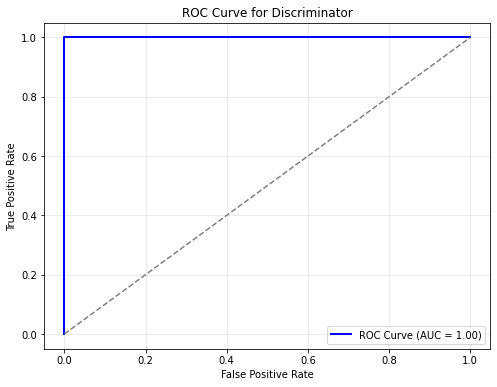

In [134]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Simulate true labels and discriminator predictions
# True labels: 1 for real images, 0 for fake images
true_labels = np.array([1] * BATCH_SIZE + [0] * BATCH_SIZE)

# Generate discriminator predictions for real and fake images
real_predictions = discriminator.predict(X_train[:BATCH_SIZE])
fake_predictions = discriminator.predict(generator.predict(np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_DIM))))

# Concatenate predictions
predictions = np.concatenate((real_predictions, fake_predictions), axis=0).flatten()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Discriminator")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
